In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
# Import data
full_df = pd.read_csv('../data/ohe_data.csv')

full_df.drop(columns=['Start_Time', 'Start_Lat', 'Start_Lng'], inplace=True)

# drop "Unnamed: 0" column if exists
if "Unnamed: 0" in full_df.columns: full_df.drop(columns=['Unnamed: 0'], inplace=True)

# correct sunrise/sunset column to be numerical if not, 0=Day, 1=Night
full_df = full_df.replace({'Day': 0, 'Night': 1})

# make any true/false values into 1/0
full_df = full_df.replace({True: 1, False: 0})

In [3]:
model_df = full_df
model_df.shape, model_df['Severity'].value_counts(normalize=True)

((2731050, 130),
 0    0.900065
 1    0.099935
 Name: Severity, dtype: float64)

In [4]:
# create X and y
X = model_df.drop('Severity', axis=1)
y = model_df['Severity']

# resample to even out categories via undersampling majority class
rus = RandomUnderSampler(random_state=1)
X_rs, y_rs = rus.fit_resample(X, y)
print(X_rs.shape, y_rs.shape)
print(y_rs.value_counts(normalize=True))

# scale X data
mms = MinMaxScaler()
X_mms = mms.fit_transform(X_rs)

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X_mms, y_rs,
                                                    stratify=y_rs,
                                                    random_state=1)

(545856, 129) (545856,)
0    0.5
1    0.5
Name: Severity, dtype: float64


In [38]:
nn = Sequential()
#nn.add(Input(shape=X_train.shape[1]))
nn.add(Dense(32, 'relu'))
nn.add(Dense(1, 'sigmoid'))

nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [39]:
%%time

nnh = nn.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
3199/3199 [==============================] - 5s 1ms/step - loss: 0.3978 - accuracy: 0.8313 - precision: 0.8196 - recall: 0.8495 - val_loss: 0.3743 - val_accuracy: 0.8417 - val_precision: 0.8304 - val_recall: 0.8587
Epoch 2/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3668 - accuracy: 0.8460 - precision: 0.8324 - recall: 0.8665 - val_loss: 0.3671 - val_accuracy: 0.8454 - val_precision: 0.8377 - val_recall: 0.8568
Epoch 3/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3618 - accuracy: 0.8481 - precision: 0.8359 - recall: 0.8663 - val_loss: 0.3653 - val_accuracy: 0.8465 - val_precision: 0.8233 - val_recall: 0.8824
Epoch 4/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3594 - accuracy: 0.8490 - precision: 0.8369 - recall: 0.8669 - val_loss: 0.3637 - val_accuracy: 0.8471 - val_precision: 0.8253 - val_recall: 0.8806
Epoch 5/20
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3574 - accuracy: 0

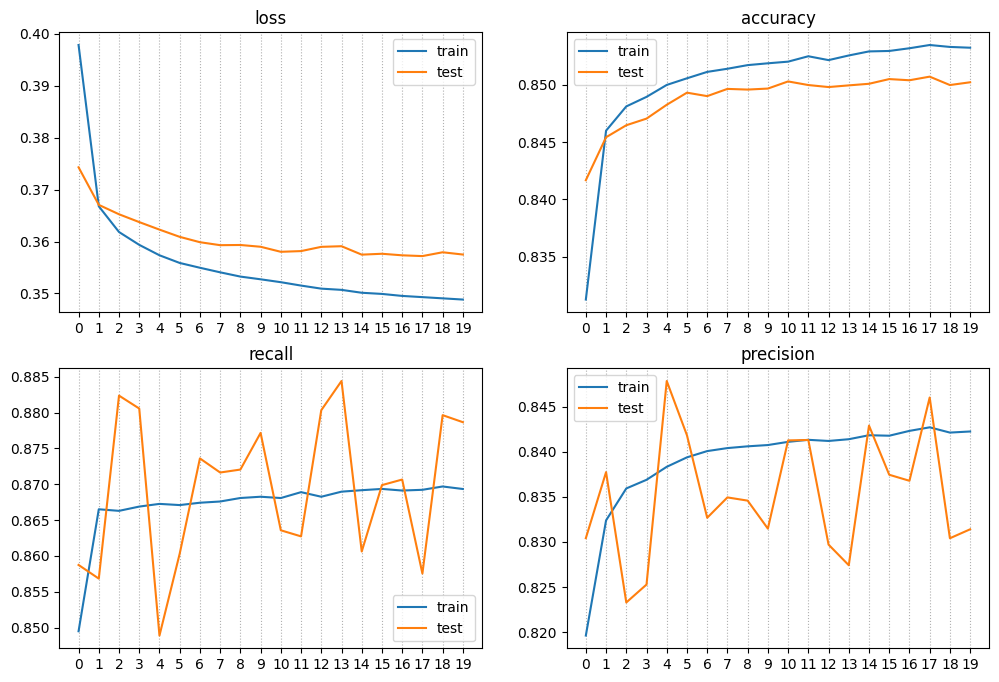

In [40]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

metrics = ['loss', 'accuracy', 'recall', 'precision']
ix = 0

for i in (0,1):
    for j in (0,1):
        m = metrics[ix]
        ax[i][j].plot(nnh.history[m], label='train')
        ax[i][j].plot(nnh.history['val_' + m], label='test')
        #ax.set_ylim(0.2, 0.3)
        ax[i][j].set_xticks(list(range(0,20)))
        ax[i][j].grid(True, axis='x', ls=':')
        ax[i][j].set_title(m)
        ax[i][j].legend()
        ix += 1

In [41]:
np.argmax(nnh.history['val_recall'])

13

In [43]:
# If we are aiming for best recall, then let's find it and 
# use that number of epochs on this run (accuracy is pretty stable so
# I'm not worrying about there being any serious accuracy issues when
# choosing based on recall)

epochs = np.argmax(nnh.history['val_recall'])

nn2 = Sequential()
#nn.add(Input(shape=X_train.shape[1]))
nn2.add(Dense(32, 'relu'))
nn2.add(Dense(1, 'sigmoid'))

nn2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

nnh2 = nn2.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/13
3199/3199 [==============================] - 5s 1ms/step - loss: 0.3985 - accuracy: 0.8308 - precision: 0.8213 - recall: 0.8457 - val_loss: 0.3749 - val_accuracy: 0.8420 - val_precision: 0.8272 - val_recall: 0.8647
Epoch 2/13
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3677 - accuracy: 0.8450 - precision: 0.8315 - recall: 0.8654 - val_loss: 0.3671 - val_accuracy: 0.8454 - val_precision: 0.8302 - val_recall: 0.8684
Epoch 3/13
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3623 - accuracy: 0.8475 - precision: 0.8342 - recall: 0.8676 - val_loss: 0.3645 - val_accuracy: 0.8470 - val_precision: 0.8325 - val_recall: 0.8689
Epoch 4/13
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3593 - accuracy: 0.8490 - precision: 0.8360 - recall: 0.8684 - val_loss: 0.3630 - val_accuracy: 0.8480 - val_precision: 0.8319 - val_recall: 0.8723
Epoch 5/13
3199/3199 [==============================] - 4s 1ms/step - loss: 0.3572 - accuracy: 0

In [44]:
test_preds = nn2.predict(X_test)

4265/4265 [==============================] - 3s 641us/step


In [51]:
cm = confusion_matrix(y_test, (test_preds >= 0.5).astype(int), normalize='true')
cm

array([[0.82969868, 0.17030132],
       [0.12813636, 0.87186364]])

In [52]:
tn, fp, fn, tp = cm.flatten()
tn, fp, fn, tp

(0.8296986751084535,
 0.17030132489154648,
 0.12813635830695275,
 0.8718636416930472)

In [53]:
recall = tp / (tp + fn)
recall

0.8718636416930472

In [56]:
# try model on a few random samples (low-budget cross-val)
n_tries = 5
for i in range(n_tries):
    sample = model_df.sample(250_000)
    sample_y = sample['Severity']
    sample_X = sample.drop('Severity', axis=1)
    mms = MinMaxScaler()
    sXmms = mms.fit_transform(sample_X)
    print(i)
    print(classification_report(sample_y, (nn2.predict(sXmms) >= 0.5).astype(int)))

0
7813/7813 [==============================] - 5s 635us/step
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    224589
           1       0.32      0.91      0.47     25411

    accuracy                           0.79    250000
   macro avg       0.65      0.84      0.67    250000
weighted avg       0.92      0.79      0.83    250000

1
7813/7813 [==============================] - 5s 639us/step
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    225085
           1       0.43      0.80      0.56     24915

    accuracy                           0.87    250000
   macro avg       0.70      0.84      0.74    250000
weighted avg       0.92      0.87      0.89    250000

2
7813/7813 [==============================] - 5s 648us/step
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    225219
           1       0.32      0.91      0.47     24781


### Conclusion

Neural Network supports logistic regression results, with perhaps slightly better accuracy. Recall is pretty decent over the tests, which is what we are looking for.